# **Churn prediction with Scikit-learn, LightGBM, XGBoost and CatBoost**

This notebook is the extension of my previous work, you can check it out at [best_model.pdf](/notebook/best_model.pdf). But this version is much more easier to read.

## Objective
The aim of this notebook is to develop a classification model that predicts customer churn for a fictional bank. The data used in this notebook is sourced from a Kaggle competition dataset, which is typical for binary classification tasks. 

## Process Overview
This notebook guides you through performing this task from Exploratory Data Analysis (EDA) to establishing a baseline model to train multiple different models for selecting the best-performing model. Given that 80% of the dataset represents non-churners, the mode of the outcome variable serves as our accuracy benchmark. However, due to the imbalanced nature of the target variable, metrics like **F1 score**, **precision**, and **recall** were prioritized to identify the best-performing model.

In pursuit of the most effective model, this notebook explores:

- Training on original vs. newly engineered features. **(This new version test OpenFE library for automatic feature generation)**
- Comparison between default and tuned hyperparameters.
- Utilization of resampling techniques to address class imbalance and potentially enhance model performance.

## Methodology
- **EDA**: Understand and identify key features, class imblances and correlations influencing the target variable. **You can check out the summary section right below to get the insights drawn from the EDA.**
- **Feature Engineering**: Applied techniques to generate new features that could improve the model's predictive power.
- **Feature Selection**: Utilized feature importances to retain the most relevant features, thus refining the model's focus and potentially enhancing its performance.
- **Model Evaluation**: Assessed model performance not only based on accuracy — due to class imbalance — but also considering precision, recall, and F1 score, with the aid of confusion matrices and ROC curves.
- **Model Comparison**: Evaluated the effectiveness of original vs. engineered features and default vs. tuned hyperparameters on model performance.
- **Resampling Techniques**: Investigated the impact of resampling methods on model outcomes, aiming to tackle the target class imbalance.
- **Hyperparameter Tuning**: Employed RandomSearchCV to tune the model parameters, thus enhancing the model performance.

In my previous work, XGBoost was the best model. In this version, since the Optuna takes quite a bit of time to execute, I will update which model or method works the best for this use case.

## Skills Showcased
Throughout this project, I have honed my skills in:

- Comprehensive **EDA** to extract insights from the dataset.
- Application of **feature engineering** to create a rich feature set for model training.
- Implementation of **feature selection** using feature importance scores.
- **Model evaluation** techniques to select the best model based on precision, recall, F1 score, and AUC.
- **Hyperparameter tuning** to enhance model performance.

## Future Steps
Moving forward, the project will extend into:

- Create ensemble model using voting or baggin from the pool of models.
- Evaluate and present the best model, how they make prediction using which features and how those features affect the outcome.

# Libraries

In [2]:
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    StratifiedKFold,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

from scipy.stats import uniform, randint
from sklearn.dummy import DummyClassifier
from sklearn import set_config
from typing import List
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import optuna
import shap
import gc

# Configuration

In [3]:
# Global configurations for sklearn:
set_config(transform_output="pandas")

# Global configurations for pandas:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.precision", 3)
pd.set_option("display.max_colwidth", None)

# Suppress warnings
warnings.filterwarnings("ignore")

In [4]:
SEED = 42

DATA_DIR = 'data/'

# Functions

In [5]:
def memory_optimization(train_data: pd.DataFrame) -> pd.DataFrame:
    """ Reduce memory usage of dataframe by modifying type of each column.

    Argument:
    train_data (pd.DataFrame): The DataFrame to be optimized.
    """
    base_memory = train_data.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {base_memory:.2f} MB')

    for column in train_data.columns:
        column_type = train_data[column].dtype

        if column_type != 'category':
            column_value_min = train_data[column].min()
            column_value_max = train_data[column].max()
            if str(column_type)[:3] == 'int':
                if column_value_min > np.iinfo(np.int8).min and column_value_max < np.iinfo(np.int8).max:
                    train_data[column] = train_data[column].astype(np.int8)
                elif column_value_min > np.iinfo(np.int16).min and column_value_max < np.iinfo(np.int16).max:
                    train_data[column] = train_data[column].astype(np.int16)
                elif column_value_min > np.iinfo(np.int32).min and column_value_max < np.iinfo(np.int32).max:
                    train_data[column] = train_data[column].astype(np.int32)
                elif column_value_min > np.iinfo(np.int64).min and column_value_max < np.iinfo(np.int64).max:
                    train_data[column] = train_data[column].astype(np.int64)  
            elif str(column_type)[:5] == 'float':
                if column_value_min > np.finfo(np.float16).min and column_value_max < np.finfo(np.float16).max:
                    train_data[column] = train_data[column].astype(np.float16)
                elif column_value_min > np.finfo(np.float32).min and column_value_max < np.finfo(np.float32).max:
                    train_data[column] = train_data[column].astype(np.float32)
                else:
                    train_data[column] = train_data[column].astype(np.float64)
        if column_type == 'object':
            train_data[column] = train_data[column].astype('category')

    optimized_memory = train_data.memory_usage().sum() / 1024**2
    optimized_percentage = 100 * (base_memory - optimized_memory) / base_memory

    print(f'Memory usage after optimization is: {optimized_memory:.2f} MB')
    print(f'Decreased by {optimized_percentage:.1f}%')

    return train_data


def print_conf_matrix(pipe: Pipeline, X_train, X_test, y_train, y_test) -> None:
    """Display the confusion matrix for the given model

    Argument:
    pipe: Pipeline of the model
    X_train, X_test, y_train, y_test: Train and test data
    """
    # Train and predict
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Display the classification report
    print(classification_report(y_test, y_pred))
    # Display the confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
    plt.title(f"{pipe.steps[1][0]}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def plot_roc_curves(pipelines: List[Pipeline], X_train, y_train, X_test, y_test) -> None:
    """Plots ROC curves for multiple pipelines.

    Args:
    pipelines: A list of Pipeline objects.
    X_train, X_test, y_train, y_test: Train and test data
    """

    # Make a bigger figure
    plt.figure(figsize=(10, 6))

    for pipeline in pipelines:
        pipeline.fit(X_train, y_train)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{pipeline.steps[3][0]} (AUC = {roc_auc:.3f})")

    plt.plot(
        [0, 1], [0, 1], linestyle="--", color="gray", linewidth=2
    )  # Create the threshold line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves of all models")
    plt.legend(loc="lower right")
    plt.show()


def get_params_for_model(params_dict: dict) -> List[dict]:
    """Returns a list of dictionaries with the parameters for the model.

    Argument:
    params_dict: A dictionary with the parameters for the model.
    """
    dicts_list = []
    for params in params_dict:
        dict = {key.split("__")[1]: value for key, value in params.items()}
        dicts_list.append(dict)
    return dicts_list

# Read data

In [6]:
# Read & display few rows
df = pd.read_csv("../data/customer_churn_records.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,SatisfactionScore,CardType,PointEarned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [7]:
%%time
# Drop unnecessary identifiers
df.drop(columns=["RowNumber", "CustomerId"], inplace=True)

# Optimize memory usage
df = memory_optimization(df)

Memory usage of dataframe is 1.22 MB
Memory usage after optimization is: 0.32 MB
Decreased by 73.4%
CPU times: user 10.4 ms, sys: 1.76 ms, total: 12.1 ms
Wall time: 13.1 ms


# EDA

In [8]:
print(f'Dataset shape: {df.shape}')

Dataset shape: (10000, 16)


In [9]:
# View columns stats
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Surname            10000 non-null  category
 1   CreditScore        10000 non-null  int16   
 2   Geography          10000 non-null  category
 3   Gender             10000 non-null  category
 4   Age                10000 non-null  int8    
 5   Tenure             10000 non-null  int8    
 6   Balance            10000 non-null  float32 
 7   NumOfProducts      10000 non-null  int8    
 8   HasCrCard          10000 non-null  int8    
 9   IsActiveMember     10000 non-null  int8    
 10  EstimatedSalary    10000 non-null  float32 
 11  Exited             10000 non-null  int8    
 12  Complain           10000 non-null  int8    
 13  SatisfactionScore  10000 non-null  int8    
 14  CardType           10000 non-null  category
 15  PointEarned        10000 non-null  int16   
dtypes: ca

## Nulls & Duplications

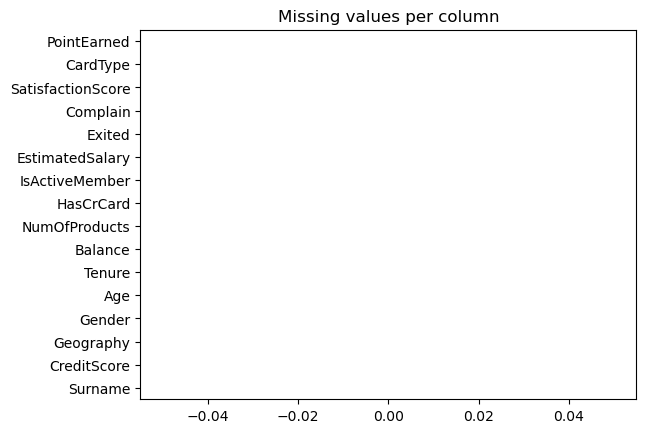

In [10]:
# Check for missing values with a horizontal bar plot
df.isnull().sum().plot(kind='barh')
plt.title('Missing values per column')
plt.show()

In [11]:
# Check if duplicates exist
print(f'Number of duplicated records: {df.duplicated().sum()}')

Number of duplicated records: 0


> Comments:

## Numerical columns

In [12]:
# Select only numerical
numerical_columns = list(df.select_dtypes(include=['float32', 'int8', 'int16']))
numerical_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'Complain',
 'SatisfactionScore',
 'PointEarned']

In [13]:
# Check statistics
df[numerical_columns].describe().round(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,SatisfactionScore,PointEarned
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,650.529,38.922,5.013,76485.891,1.530,0.706,0.515,100090.234,0.204,0.204,3.014,606.515
std,96.653,10.488,2.892,62398.953,0.582,0.456,0.500,57510.473,0.403,0.403,1.406,225.925
min,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000,0.000,1.000,119.000
25%,584.000,32.000,3.000,0.000,1.000,0.000,0.000,51002.109,0.000,0.000,2.000,410.000
50%,652.000,37.000,5.000,97198.539,1.000,1.000,1.000,100193.914,0.000,0.000,3.000,605.000
75%,718.000,44.000,7.000,127644.238,2.000,1.000,1.000,149388.254,0.000,0.000,4.000,801.000
max,850.000,92.000,10.000,250898.094,4.000,1.000,1.000,199992.484,1.000,1.000,5.000,1000.000


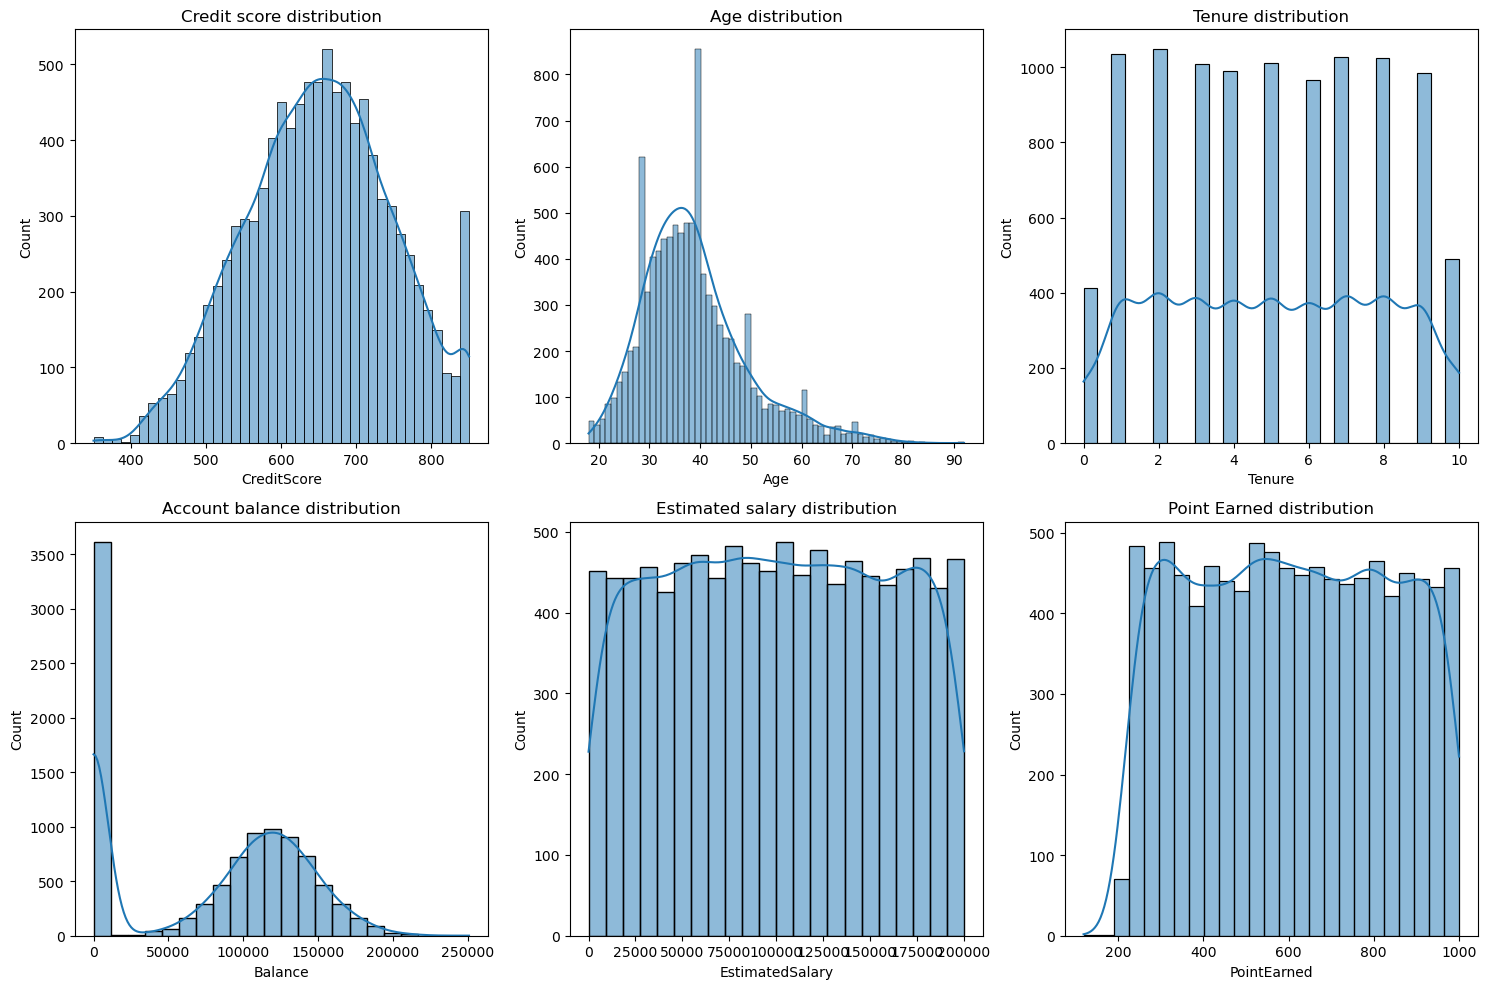

In [14]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(data=df, x="CreditScore", kde=True)
plt.title("Credit score distribution")

plt.subplot(2, 3, 2)
sns.histplot(data=df, x="Age", kde=True)
plt.title("Age distribution")

plt.subplot(2, 3, 3)
sns.histplot(data=df, x="Tenure", kde=True)
plt.title("Tenure distribution")

plt.subplot(2, 3, 4)
sns.histplot(data=df, x="Balance", kde=True)
plt.title("Account balance distribution")

plt.subplot(2, 3, 5)
sns.histplot(data=df, x="EstimatedSalary", kde=True)
plt.title("Estimated salary distribution")

plt.subplot(2, 3, 6)
sns.histplot(data=df, x="PointEarned", kde=True)
plt.title("Point Earned distribution")

plt.tight_layout()
plt.show()

> Comments:
> 1. The distribution of credit score is approximately normal.
> 2. The majority of customers are between 30 to 40 years old.
> 3. Tenure is evenly distributed, suggesting a consistent acquisition of new customers over time.
> 4. There is a significant number of customers with 0 balance, may due to some possible errors; if excluding the 0 balances, then we can see a normal distribution in this feature.
> 5. Salaries are evenly distributed, indicating no significant skew towards higher or lower salaries There are customers with a wide range of estimated salaries, suggesting diverse income levels among customers.
> 6. Points earned are evenly distributed, suggesting a consistent earning pattern among customers.

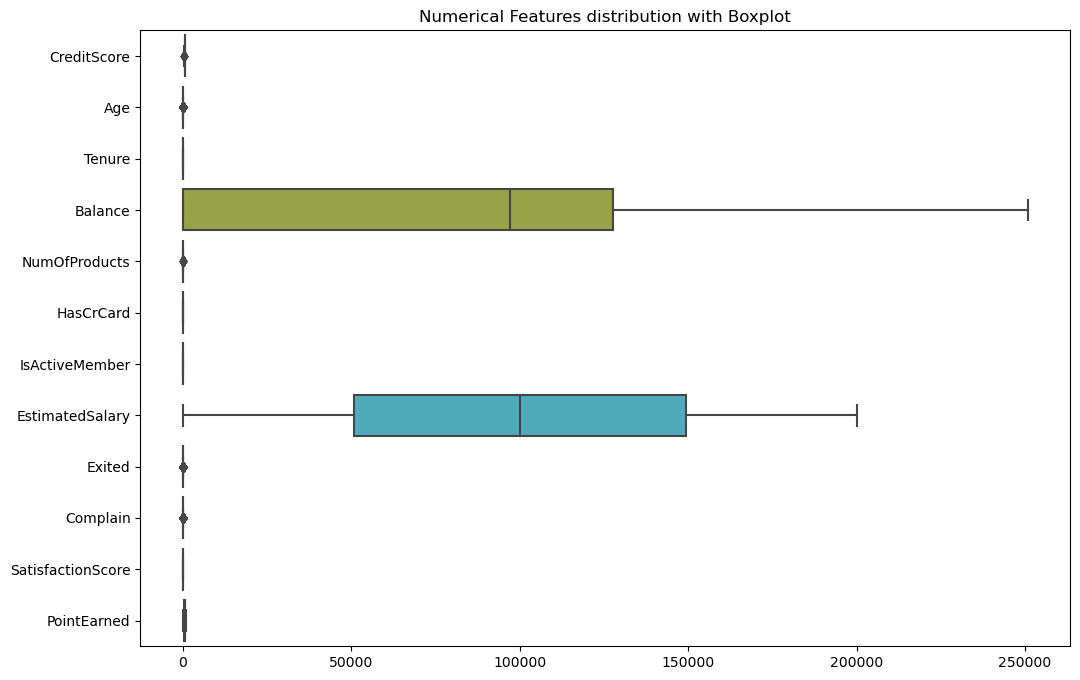

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[numerical_columns], orient='h')
plt.title('Numerical Features distribution with Boxplot')
plt.show()

> Comment: The scale of numerical features is not the same, hence the different in the boxplot. But no sign of significant outliers displayed.

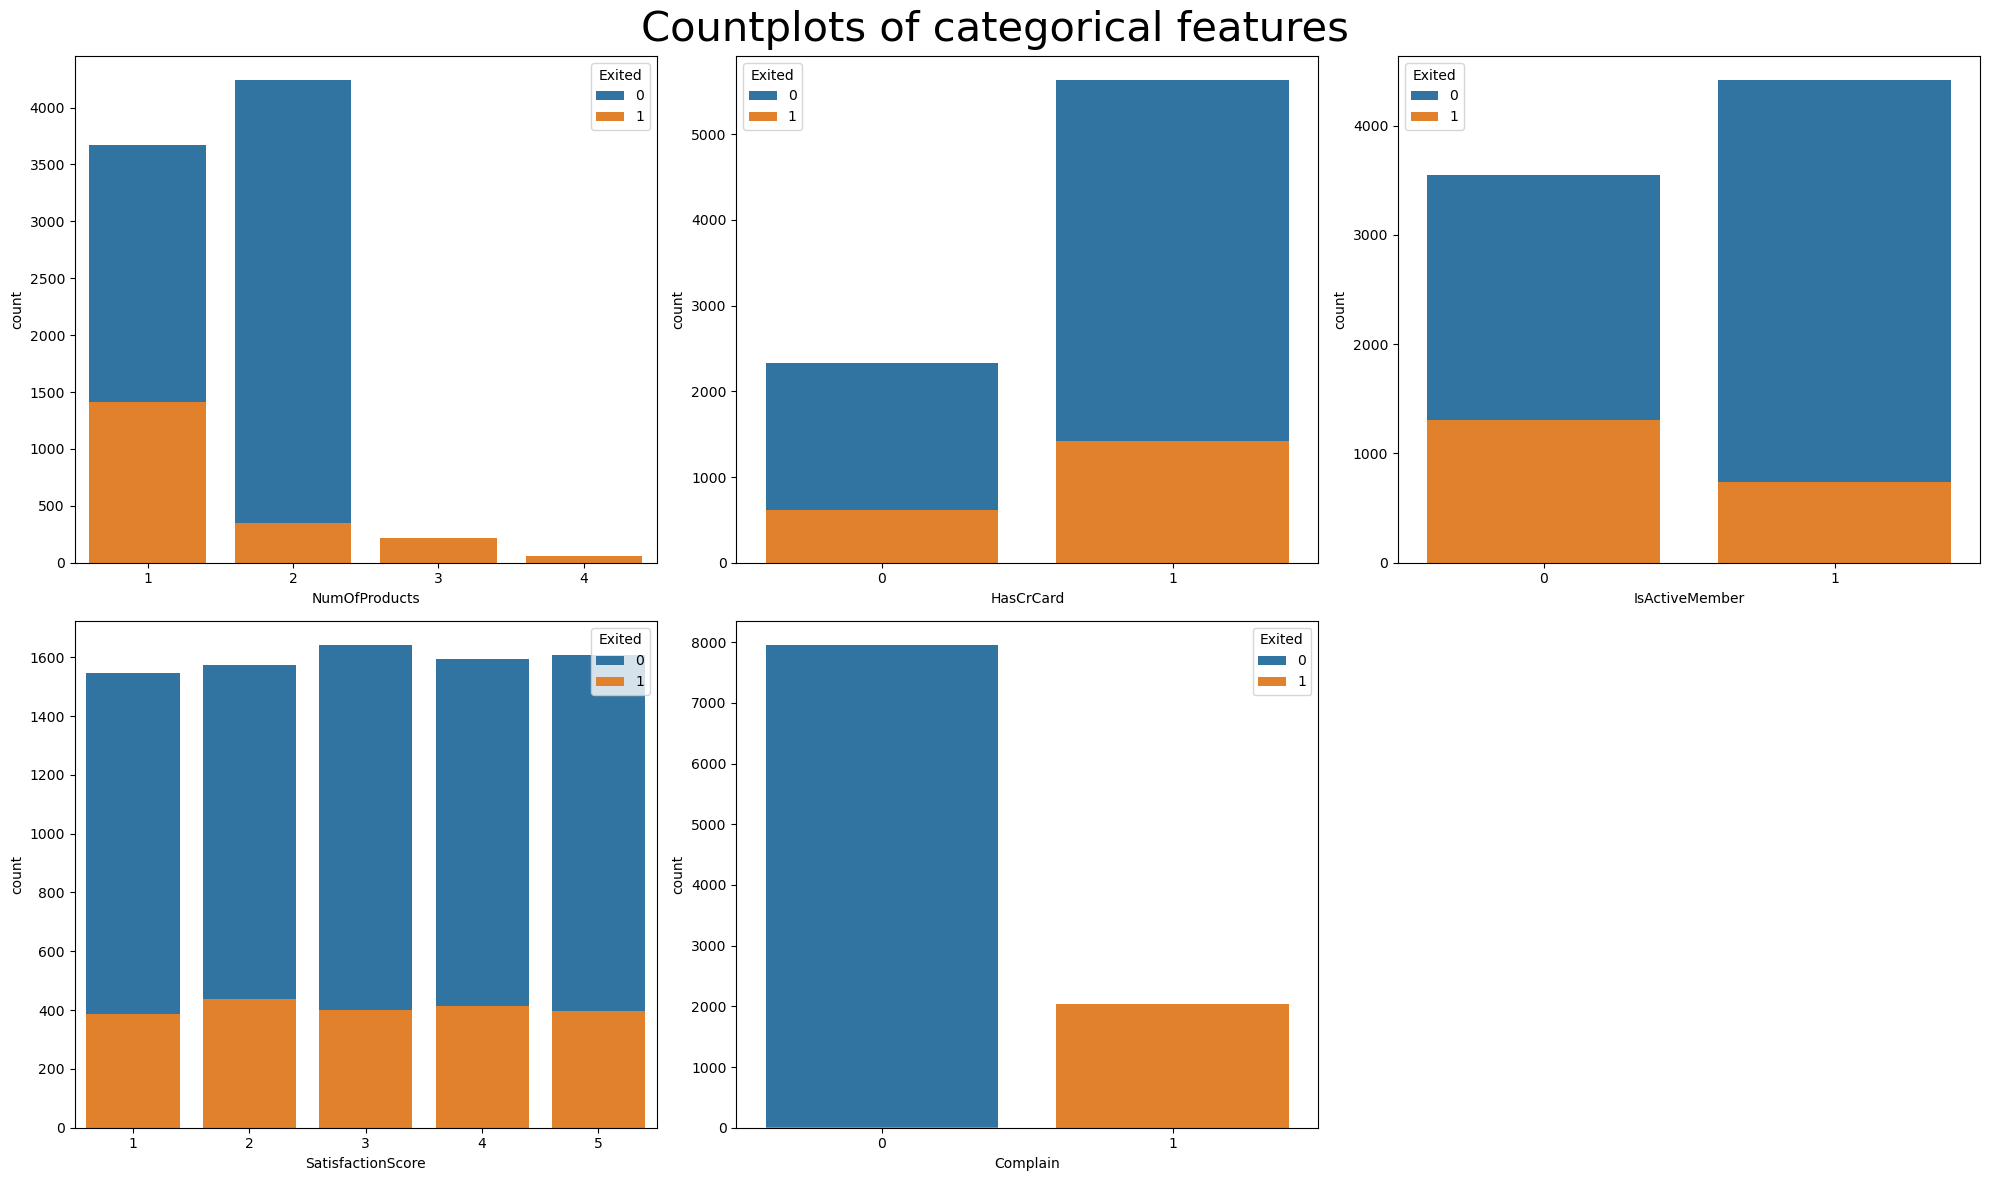

In [16]:
# Create grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes[1, 2].remove()  # Remove the empty subplot

sns.countplot(data=df, x="NumOfProducts", hue="Exited", dodge=False, ax=axes[0, 0])
sns.countplot(data=df, x="HasCrCard", hue="Exited", dodge=False, ax=axes[0, 1])
sns.countplot(data=df, x="IsActiveMember", hue="Exited", dodge=False, ax=axes[0, 2])
sns.countplot(data=df, x="SatisfactionScore", hue="Exited", dodge=False, ax=axes[1, 0])
sns.countplot(data=df, x="Complain", hue="Exited", dodge=False, ax=axes[1, 1])

plt.suptitle("Countplots of categorical features", fontsize=30)
plt.tight_layout()
plt.show()

> Comments:
> 1. The majority of customers has 1 to 2 products with 1-product customers are likely to leave the service; those have 3 to 4 still chosed to leave despite having lots of products with the bank.
> 2. The proportion of churn rates across SatisfactionScore is consistent.
> 3. Most of the customers have credit card, and the proportion of churners for no-credit-card customers is higher than those possess credit cards, which is normal.
> 4. The same pattern exists with is customer being active or not. 
> 5. There seems to be a correlation between complains from customers and customer exits.

In [17]:
# Check the skewness of the numerical columns
num_col_to_check = ["CreditScore", "Age", "Balance"]

for column_name in num_col_to_check:
    skewness = df[column_name].skew()
    print(f"The skewness coefficient of {column_name} is: {skewness}")

The skewness coefficient of CreditScore is: -0.07160660820092675
The skewness coefficient of Age is: 1.0113202630234552
The skewness coefficient of Balance is: -0.14110878109931946


> Comment: Age is highly skewed.

## Categorical columns

In [18]:
# Select only categorical
categorical_columns = list(df.select_dtypes(include=['category']))
categorical_columns

['Surname', 'Geography', 'Gender', 'CardType']

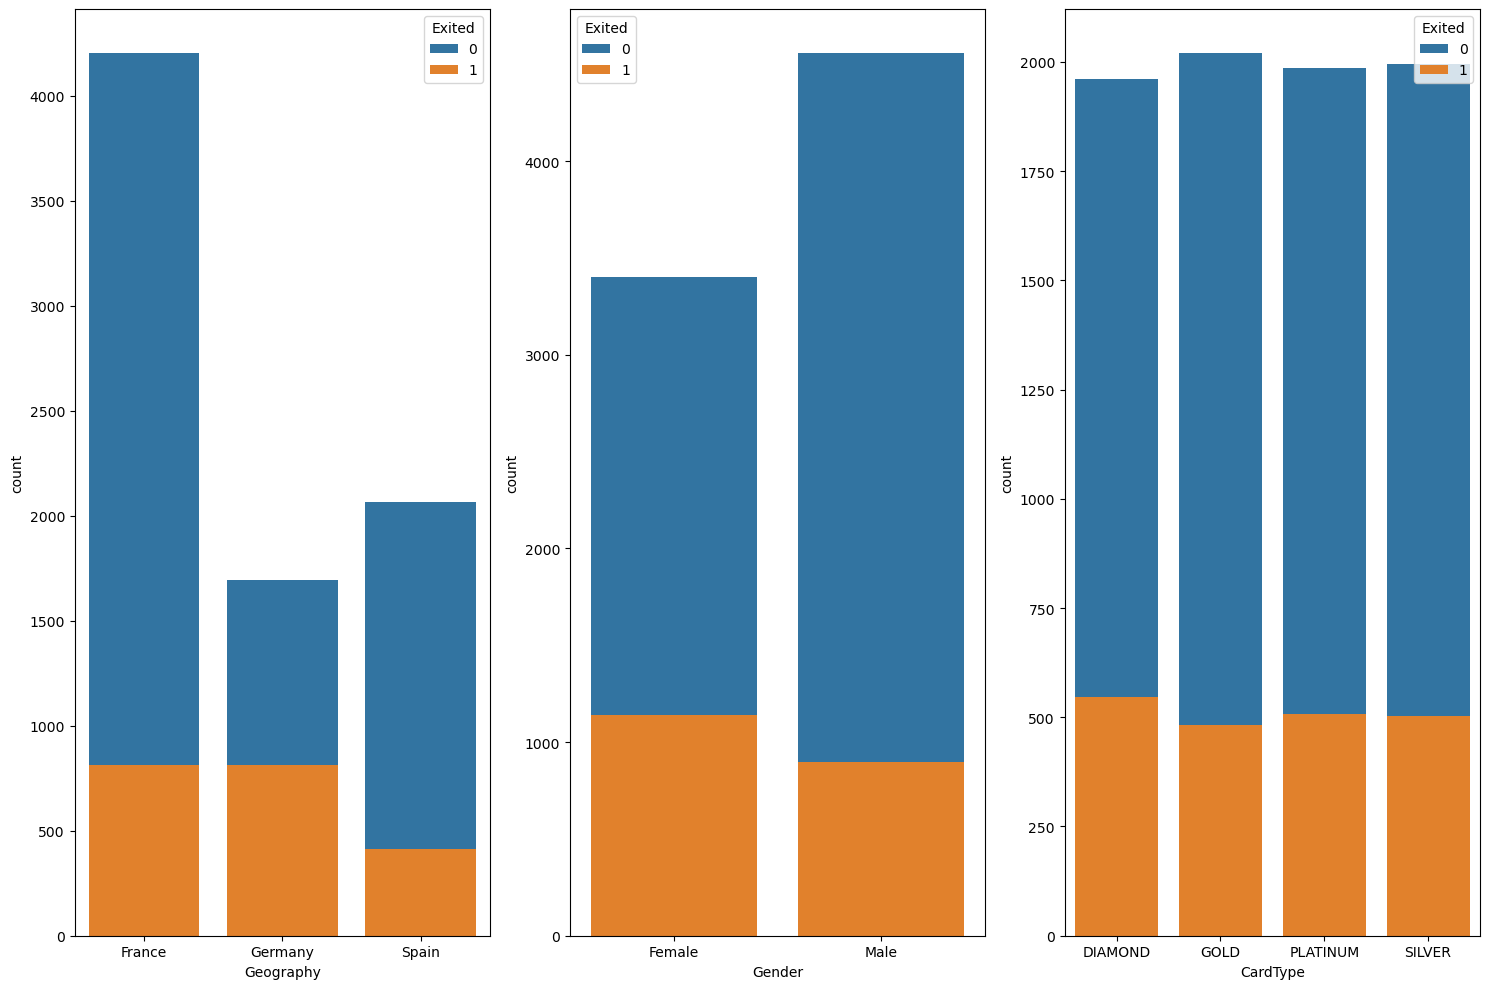

In [19]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x="Geography", hue="Exited", dodge=False)

plt.subplot(1, 3, 2)
sns.countplot(data=df, x="Gender", hue="Exited", dodge=False)

plt.subplot(1, 3, 3)
sns.countplot(data=df, x="CardType", hue="Exited", dodge=False)

plt.tight_layout()
plt.show()

> Comments:
> 1. France has the highest number of customers, but the proportion of churners is lower compared to Germany and Spain.
> 2. Female customers have a higer proportion of exits compared to male customers.
> 3. The churn rates are consistent across different card types, however, DIAMOND cardholders have a slightly higher churn rate indicate a possible dissatisfaction or abnormal behavior, considering that DIAMOND cardholders usually would stay with the bank since they have good relationship with them.

## Relationship

In [20]:
# Delete columns that are not needed
corr_cal_df = df.copy().drop(["Surname"], axis=1)

# Convert the categorical columns to numerical for correlation matrix
corr_cal_df.Gender = corr_cal_df.Gender.astype("category").cat.codes
corr_cal_df.Geography = corr_cal_df.Geography.astype("category").cat.codes
corr_cal_df["CardType"] = corr_cal_df["CardType"].astype("category").cat.codes

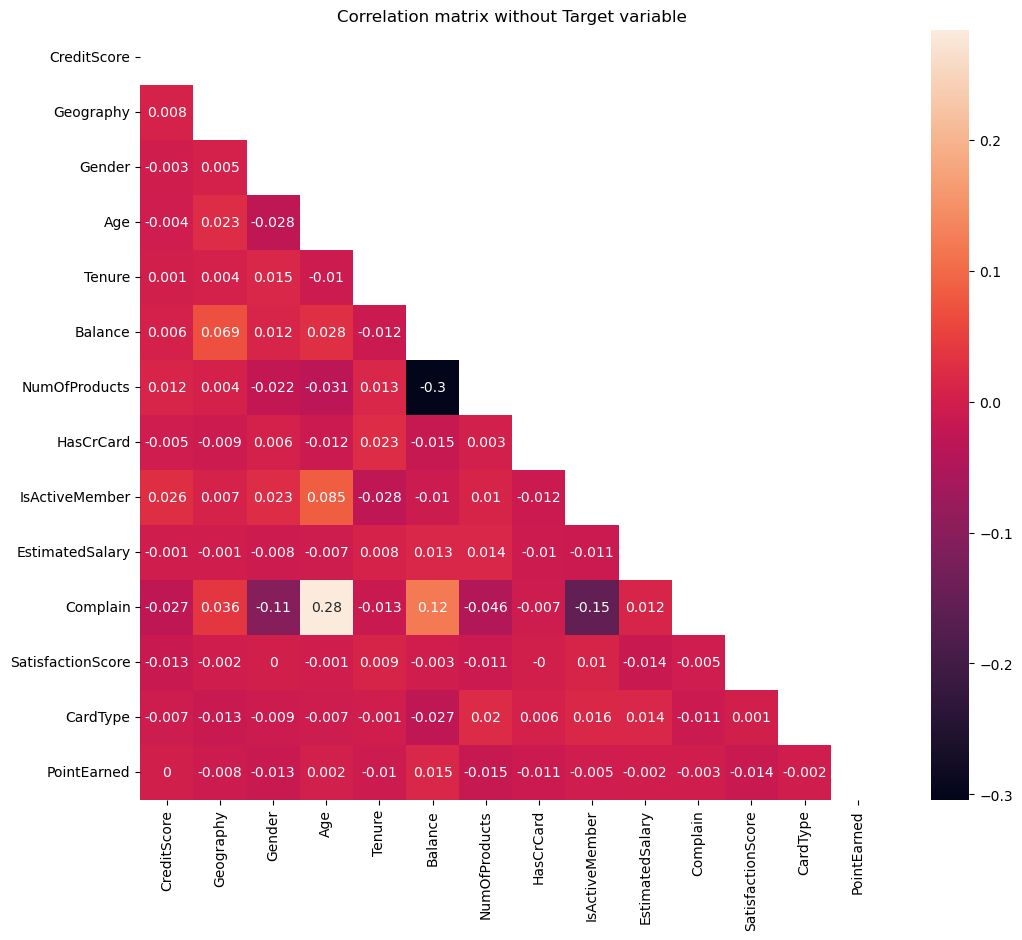

In [21]:
# Calculate the correlation matrix without target
no_target_corr = corr_cal_df.drop(["Exited"], axis=1)

# Create a mask for the upper triangle
mask_up_tri = np.triu(np.ones_like(no_target_corr.corr(), dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(no_target_corr.corr().round(3), annot=True, mask=mask_up_tri)
plt.title("Correlation matrix without Target variable")
plt.show()

In [22]:
# Calculate the correlation matrix with target
corr_cal_df.corr().abs()["Exited"].sort_values(ascending=False)

Exited               1.000
Complain             0.996
Age                  0.285
IsActiveMember       0.156
Balance              0.119
Gender               0.106
NumOfProducts        0.048
Geography            0.036
CreditScore          0.027
Tenure               0.014
EstimatedSalary      0.012
CardType             0.011
HasCrCard            0.007
SatisfactionScore    0.006
PointEarned          0.005
Name: Exited, dtype: float64

> Comment: There is no significant correlation between features, but there is indeed a correlation between complain and target variable.

## Target

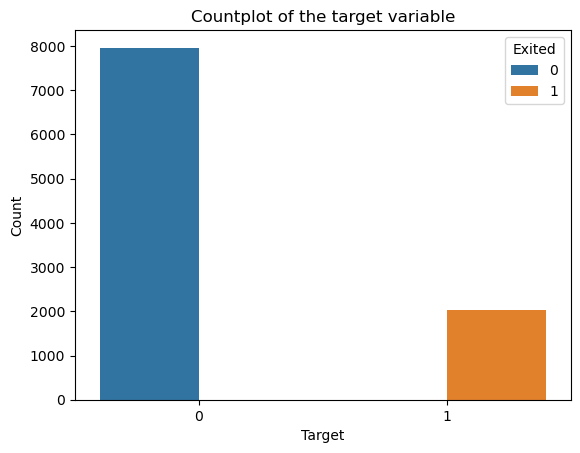

In [23]:
sns.countplot(data=df, x="Exited", hue="Exited")
plt.title("Countplot of the target variable")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

## Summary

1. The dataset does not contain null or duplicated values, so we don't need to do any imputation.
2. The dataset contains a mix of numerical and categorical variables, with some categorical features are in numeric form.
3. Specific regions (Germany and Spain) and female customers show higher exit rates, indicating a need for targeted customer retention strategies in these segments.
4. Most customers are middle-aged with moderate credit scores, which might be the target demographic for marketing and service improvements.
5. The large number of customers with zero balance might indicate inactive or less engaged customers, highlighting a potential area for customer interactions.
6. The even distribution suggests a stable customer base and consistent earning patterns, which can be leveraged for loyalty programs and rewards initiatives.

# Pre-processing

In [24]:
features = df.drop(['Surname', 'Complain', 'Exited'], axis=1)
target = df[['Exited']]

del df
gc.collect()

31618

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, random_state=SEED, stratify=target, shuffle=True
)

# Check the shape of the train and test data
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Train data shape: (9000, 13), (9000, 1)
Test data shape: (1000, 13), (1000, 1)


# Feature engineering

## Original features

In [26]:
%%time
binary_cols = ["Gender"]
ordinal_cols = ["CardType"]
ohe_col = ["Geography"]

preprocessor = ColumnTransformer(
    transformers=[
        ("binary", OrdinalEncoder(), binary_cols),
        (
            "ordinal",
            OrdinalEncoder(categories=[["SILVER", "GOLD", "PLATINUM", "DIAMOND"]]),
            ordinal_cols,
        ),
        ("ohe", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ohe_col),
    ],
    remainder="passthrough",
)

X_train_processed_test = preprocessor.fit_transform(X_train)
X_test_processed_test = preprocessor.transform(X_test)

# Checking the transformer object
print(f"Before: {X_train.shape}")
print(f"After: {X_train_processed_test.shape}")

del X_train_processed_test, X_test_processed_test
gc.collect()

Before: (9000, 13)
After: (9000, 15)
CPU times: user 289 ms, sys: 2.32 ms, total: 291 ms
Wall time: 189 ms


27746

## Generated features

In [ ]:
#TODO Use OpenFE to generate new features

In [ ]:
#TODO Use feature selection to select the best features

# Metric

Since we encounter an imbalance dataset, the usual accuracy metric will not yield the most promising result. We should prioritize different metrics like **F1 score**, **Precision**, **Recall** that work better with imbalance datasets. 

In real life situation, it is best to have a define metric that take into account different scenarios such as the cost of retaining customers to the cost of lauching retention campaigns or even consider how not correctly predicting churners would affect the business. Answering these questions would help determine which of the above metrics is appropriate to maximize the profit for the organization.

In this notebook, since I do not have much information to work with, it is best to use **F1 score** as it combines both Precision and Recall. Should there be two models with the same F1 score, I can use the ROC curves and AUC values to select the best between them.

# Modeling

## Baseline model

In [27]:
# Create baseline dummy model
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
dummy_pred = dummy_clf.predict(X_test)

print(f"Dummy classifier accuracy: {accuracy_score(y_test, dummy_pred)}")

Dummy classifier accuracy: 0.796


> Comment: Created a dummy model as a baseline to compare the other algorithms. The baseline for this classification task is to predict the mode of the target variable. In this case, since the churn vs non-churn distribution is 1 to 4, if we predict randomly then 80% of the time a customer would be classified as non-churner. -> This is to demonstrate the math behind, we will be focusing more on the F1 score.

## Comparison models

### Orginal features

#### Without resampling

In [28]:
# Compute the class weights
weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train.values.ravel())

In [29]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=SEED, n_jobs=-1)
rf = RandomForestClassifier(criterion='log_loss', n_jobs=-1, class_weight='balanced', random_state=SEED)
gdb = HistGradientBoostingClassifier(class_weight='balanced', random_state=SEED)
xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', class_weight=weights, seed=SEED, verbosity=0)
lgb = LGBMClassifier(objective='binary', is_unbalance=True, seed=SEED, n_jobs=-1, verbose=-1)
cat = CatBoostClassifier(objective='Logloss', class_weights=weights, verbose=False, random_state=SEED)

In [30]:
log_reg_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("log_classifier", log_reg),
    ]
)

rf_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rf_classifier", rf),
    ]
)

gdb_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("boost_classifier", gdb),
    ]
)

xgb_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("xgb_classifier", xgb)]
)

lgb_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("lgb_classifier", lgb)]
)

cat_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("cat_classifier", cat)]
)

In [31]:
names = ["Logistic Regression", "Random Forest", "Hist Gradient Boosting", "XGBoost", "LightGBM", "CatBoost"]
scoring = ["accuracy", "precision", "recall", "roc_auc", "f1"]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
%%time
log_cv = cross_validate(log_reg_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
rf_cv = cross_validate(rf_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
gdb_cv = cross_validate(gdb_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
xgb_cv = cross_validate(xgb_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
lgb_cv = cross_validate(lgb_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
cat_cv = cross_validate(cat_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)

cv_scores = [log_cv, rf_cv, gdb_cv, xgb_cv, lgb_cv, cat_cv]

# Create a dataframe with the results
org_feats_df = pd.DataFrame(
    {
        "Model name": names,
        "Mean Accuracy": [np.mean(scores["test_accuracy"]) for scores in cv_scores],
        "Mean Precision": [np.mean(scores["test_precision"]) for scores in cv_scores],
        "Mean Recall": [np.mean(scores["test_recall"]) for scores in cv_scores],
        "Mean ROC AUC": [np.mean(scores["test_roc_auc"]) for scores in cv_scores],
        "Mean F1 Score": [np.mean(scores["test_f1"]) for scores in cv_scores],
    }
)
org_feats_df.set_index("Model name", inplace=True)

"""
CPU times: user 138 ms, sys: 168 ms, total: 306 ms
Wall time: 17.5 s
"""

In [36]:
org_feats_df

,Mean Accuracy,Mean Precision,Mean Recall,Mean ROC AUC,Mean F1 Score
Model name,,,,,
Logistic Regression,0.703,0.376,0.692,0.766,0.487
Random Forest,0.860,0.792,0.426,0.853,0.554
Hist Gradient Boosting,0.825,0.557,0.694,0.860,0.618
XGBoost,0.854,0.698,0.498,0.840,0.581
LightGBM,0.821,0.548,0.701,0.857,0.615
CatBoost,0.826,0.559,0.697,0.862,0.620


#### With resampling

##### Over sampling

In [ ]:
%%time
# Define the sampling techniques
over_samplings = {
    "SMOTE": SMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
}

# Define the models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "Hist Gradient Boosting": gdb,
    "XGBoost": xgb,
    "LightGBM": lgb,
    "CatBoost": cat,
}

# Create a DataFrame to store the results
diff_overs_df = pd.DataFrame(
    columns=[
        "Sampling Technique",
        "Model",
        "Mean ROC AUC",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# For each sampling technique
for sampling_name, sampling in over_samplings.items():
    # For each model
    for model_name, model in models.items():
        # Create a pipeline with the sampling technique and the model
        pipeline = imbPipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("sampler", sampling),
                ("model", model),
            ]
        )

        # Evaluate the pipeline using cross-validation
        cv_results = cross_validate(
            pipeline, X_train, y_train, cv=kfold, scoring=scoring
        )

        # Add the results to the DataFrame
        diff_overs_df = pd.concat(
            [
                diff_overs_df,
                pd.DataFrame(
                    {
                        "Sampling Technique": [sampling_name],
                        "Model": [model_name],
                        "Mean ROC AUC": [cv_results["test_roc_auc"].mean()],
                        "Accuracy": [cv_results["test_accuracy"].mean()],
                        "Precision": [cv_results["test_precision"].mean()],
                        "Recall": [cv_results["test_recall"].mean()],
                        "F1 Score": [cv_results["test_f1"].mean()],
                    }
                ),
            ],
            ignore_index=True,
        )

"""
CPU times: user 3min 52s, sys: 1min 47s, total: 5min 40s
Wall time: 1min 59s
"""

##### Under sampling

In [ ]:
%%time
# Define the undersampling techniques
under_samplings = {
    "RandomUnderSampler": RandomUnderSampler(random_state=SEED),
    "NearMiss": NearMiss(version=1, n_neighbors=3),
}

# Create a DataFrame to store the results
diff_unders_df = pd.DataFrame(
    columns=[
        "Undersampling Technique",
        "Model",
        "Mean ROC AUC",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# For each undersampling technique
for sampling_name, sampling in under_samplings.items():
    # For each model
    for model_name, model in models.items():
        # Create a pipeline with the undersampling technique and the model
        pipeline = imbPipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("sampler", sampling),
                ("model", model),
            ]
        )

        # Evaluate the pipeline using cross-validation
        cv_results = cross_validate(
            pipeline, X_train, y_train, cv=kfold, scoring=scoring
        )

        # Add the results to the DataFrame
        diff_unders_df = pd.concat(
            [
                diff_unders_df,
                pd.DataFrame(
                    {
                        "Undersampling Technique": [sampling_name],
                        "Model": [model_name],
                        "Mean ROC AUC": [cv_results["test_roc_auc"].mean()],
                        "Accuracy": [cv_results["test_accuracy"].mean()],
                        "Precision": [cv_results["test_precision"].mean()],
                        "Recall": [cv_results["test_recall"].mean()],
                        "F1 Score": [cv_results["test_f1"].mean()],
                    }
                ),
            ],
            ignore_index=True,
        )

""" 
CPU times: user 2min 8s, sys: 1min 11s, total: 3min 19s
Wall time: 47.5 s
"""

##### Sampling combination

In [ ]:
%%time
# Using predifined resampler
smotetomek = SMOTETomek()

# Create a DataFrame to store the results
resampling_comb_df = pd.DataFrame(
    columns=[
        "Model",
        "Mean ROC AUC",
        "Accuracy",
        "Precision",
        "Recall",
        "F1 Score",
    ]
)

# For each model
for model_name, model in models.items():
    # Create a pipeline with the undersampling technique and the model
    pipeline = imbPipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("sampler", smotetomek),
            ("model", model),
        ]
    )

    # Evaluate the pipeline using cross-validation
    cv_results = cross_validate(
        pipeline, X_train, y_train, cv=kfold, scoring=scoring
    )

    # Add the results to the DataFrame
    resampling_comb_df = pd.concat(
        [
            resampling_comb_df,
            pd.DataFrame(
                {
                    "Model": [model_name],
                    "Mean ROC AUC": [cv_results["test_roc_auc"].mean()],
                    "Accuracy": [cv_results["test_accuracy"].mean()],
                    "Precision": [cv_results["test_precision"].mean()],
                    "Recall": [cv_results["test_recall"].mean()],
                    "F1 Score": [cv_results["test_f1"].mean()],
                }
            ),
        ],
        ignore_index=True,
    )

""" 
CPU times: user 2min 19s, sys: 1min 22s, total: 3min 41s
Wall time: 1min 13s
"""

In [39]:
resampling_comb_df

,Model,Mean ROC AUC,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.743,0.727,0.391,0.600,0.473
1,Random Forest,0.843,0.848,0.663,0.513,0.578
2,Hist Gradient Boosting,0.855,0.855,0.687,0.534,0.600
3,XGBoost,0.840,0.848,0.666,0.512,0.578
4,LightGBM,0.858,0.857,0.695,0.537,0.605
5,CatBoost,0.854,0.801,0.509,0.716,0.595


In [51]:
diff_overs_df

,Sampling Technique,Model,Mean ROC AUC,Accuracy,Precision,Recall,F1 Score
0,SMOTE,Logistic Regression,0.742,0.730,0.395,0.601,0.476
1,SMOTE,Random Forest,0.844,0.848,0.668,0.507,0.576
2,SMOTE,Hist Gradient Boosting,0.858,0.859,0.706,0.535,0.608
3,SMOTE,XGBoost,0.842,0.850,0.671,0.522,0.587
4,SMOTE,LightGBM,0.858,0.857,0.696,0.529,0.601
5,SMOTE,CatBoost,0.854,0.800,0.507,0.715,0.593
6,ADASYN,Logistic Regression,0.740,0.726,0.390,0.597,0.471
7,ADASYN,Random Forest,0.846,0.849,0.665,0.519,0.583
8,ADASYN,Hist Gradient Boosting,0.858,0.856,0.692,0.526,0.598
9,ADASYN,XGBoost,0.842,0.848,0.660,0.524,0.584


In [49]:
diff_unders_df

,Undersampling Technique,Model,Mean ROC AUC,Accuracy,Precision,Recall,F1 Score
0,RandomUnderSampler,Logistic Regression,0.765,0.703,0.377,0.696,0.489
1,RandomUnderSampler,Random Forest,0.852,0.793,0.495,0.751,0.597
2,RandomUnderSampler,Hist Gradient Boosting,0.855,0.788,0.488,0.750,0.591
3,RandomUnderSampler,XGBoost,0.841,0.776,0.469,0.746,0.576
4,RandomUnderSampler,LightGBM,0.855,0.789,0.489,0.754,0.593
5,RandomUnderSampler,CatBoost,0.862,0.611,0.334,0.914,0.489
6,NearMiss,Logistic Regression,0.630,0.472,0.254,0.821,0.387
7,NearMiss,Random Forest,0.694,0.479,0.265,0.879,0.407
8,NearMiss,Hist Gradient Boosting,0.663,0.477,0.267,0.895,0.411
9,NearMiss,XGBoost,0.698,0.474,0.266,0.896,0.410


> Comment: Aside from the undersampling that performed worse than the other two, bot oversampling and sampling combination don't improve at all compared to using the default parameters of the models. Could be because there's already a parameter for models that can specify the weights of classes.

### Hyperparameter tuning with Optuna

In [ ]:
""" %%time
def objective(trial):
    params = {
        'log_classifier__solver': trial.suggest_categorical('log_classifier__solver', ['liblinear', 'lbfgs', 'saga', 'newton-cg', 'sag']),
        'log_classifier__penalty': trial.suggest_categorical('log_classifier__penalty', ['l1', 'l2', 'elasticnet', None]),
        'log_classifier__C': trial.suggest_loguniform('log_classifier__C', 1e-5, 1e5),
        'log_classifier__max_iter': trial.suggest_int('log_classifier__max_iter', 50, 500),
    }

    # Check for invalid combinations
    if params['log_classifier__solver'] in ['sag', 'lbfgs', 'newton-cg'] and params['log_classifier__penalty'] not in ['l2', None]:
        return 0

    if params['log_classifier__solver'] == 'liblinear' and params['log_classifier__penalty'] not in ['l1', 'l2']:
        return 0
    
    if params['log_classifier__penalty'] == 'elasticnet' and 'l1_ratio' not in params:
        return 0

    log_reg_pipe.set_params(**params)

    cv_results = cross_validate(log_reg_pipe, X_train, y_train, cv=kfold, scoring='f1')
    mean_f1 = np.mean(cv_results['test_score'])

    return mean_f1


study = optuna.create_study(study_name="Logistic Regression", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print() """

""" Attemp 1
Number of finished trials:  100
Best trial:
  Value:  0.49766927412077633
  Params: 
    log_classifier__solver: newton-cg
    log_classifier__penalty: l2
    log_classifier__C: 39.53320674618134
    log_classifier__max_iter: 476

CPU times: user 4min 10s, sys: 15 s, total: 4min 25s
Wall time: 2min 10s
"""

In [ ]:
""" %%time
def objective(trial):
    params = {
        'rf_classifier__n_estimators': trial.suggest_int('rf_classifier__n_estimators', 50, 1000),
        'rf_classifier__criterion': trial.suggest_categorical('rf_classifier__criterion', ['gini', 'entropy', 'log_loss']),
        'rf_classifier__max_depth': trial.suggest_int('rf_classifier__max_depth', 3, 20),
        'rf_classifier__min_samples_split': trial.suggest_int('rf_classifier__min_samples_split', 2, 20),
        'rf_classifier__min_samples_leaf': trial.suggest_int('rf_classifier__min_samples_leaf', 1, 20),
        'rf_classifier__max_features': trial.suggest_categorical('rf_classifier__max_features', ['sqrt', 'log2', None]),
        'rf_classifier__bootstrap': trial.suggest_categorical('rf_classifier__bootstrap', [True, False]),
    }

    rf_pipe.set_params(**params)

    cv_results = cross_validate(rf_pipe, X_train, y_train, cv=kfold, scoring='f1')
    mean_f1 = np.mean(cv_results['test_score'])

    return mean_f1

study = optuna.create_study(study_name="Random Forest", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print() """

""" Attemp 1
Number of finished trials:  100
Best trial:
  Value:  0.62245460984628
  Params: 
    rf_classifier__n_estimators: 989
    rf_classifier__criterion: entropy
    rf_classifier__max_depth: 14
    rf_classifier__min_samples_split: 19
    rf_classifier__min_samples_leaf: 16
    rf_classifier__max_features: None
    rf_classifier__bootstrap: True

CPU times: user 14min 55s, sys: 4min 4s, total: 19min
Wall time: 53min 55s
"""

In [ ]:
""" %%time
def objective(trial):
    params = {
        'boost_classifier__learning_rate': trial.suggest_loguniform('boost_classifier__learning_rate', 1e-3, 0.5),
        'boost_classifier__max_iter': trial.suggest_int('boost_classifier__max_iter', 50, 1000),
        'boost_classifier__max_depth': trial.suggest_int('boost_classifier__max_depth', 3, 40),
        'boost_classifier__max_leaf_nodes': trial.suggest_int('boost_classifier__max_leaf_nodes', 2, 40),
        'boost_classifier__min_samples_leaf': trial.suggest_int('boost_classifier__min_samples_leaf', 2, 40),
        'boost_classifier__l2_regularization': trial.suggest_uniform('boost_classifier__l2_regularization', 0, 1.0),
    }

    # Set the parameters for the pipeline
    gdb_pipe.set_params(**params)

    cv_results = cross_validate(gdb_pipe, X_train, y_train, cv=kfold, scoring='f1')
    mean_f1 = np.mean(cv_results['test_score'])

    return mean_f1

study = optuna.create_study(study_name="Hist Gradient Boosting", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print() """

""" Attemp 1
Number of finished trials:  100
Best trial:
  Value:  0.621364444725104
  Params: 
    boost_classifier__learning_rate: 0.01880121280360771
    boost_classifier__max_iter: 637
    boost_classifier__max_depth: 6
    boost_classifier__max_leaf_nodes: 40
    boost_classifier__min_samples_leaf: 17
    boost_classifier__l2_regularization: 0.47857021797820076

CPU times: user 2h 58min 27s, sys: 16h 26min 22s, total: 19h 24min 50s
Wall time: 3h 27min 34s
"""

In [ ]:
""" 
%%time
def objective(trial):
    params = {
        'xgb_classifier__learning_rate': trial.suggest_float("xgb_classifier__learning_rate", 1e-3, 0.1, log=True),
        'xgb_classifier__n_estimators': trial.suggest_int('xgb_classifier__n_estimators', 50, 1000),
        'xgb_classifier__max_depth': trial.suggest_int('xgb_classifier__max_depth', 1, 10),
        'xgb_classifier__min_child_weight': trial.suggest_int('xgb_classifier__min_child_weight', 1, 20),
        'xgb_classifier__subsample': trial.suggest_float("xgb_classifier__subsample", 0.05, 1.0),
        'xgb_classifier__colsample_bytree': trial.suggest_float("xgb_classifier__colsample_bytree", 0.05, 1.0),
    }

    xgb_pipe.set_params(**params)

    cv_results = cross_validate(xgb_pipe, X_train, y_train, cv=kfold, scoring='f1')
    mean_f1 = np.mean(cv_results['test_score'])

    return mean_f1

study = optuna.create_study(study_name="XGBoost", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print() """

""" 
Number of finished trials:  100
Best trial:
  Value:  0.5936880896812479
  Params: 
    xgb_classifier__learning_rate: 0.06765184534467797
    xgb_classifier__n_estimators: 866
    xgb_classifier__max_depth: 3
    xgb_classifier__min_child_weight: 16
    xgb_classifier__subsample: 0.772733831518399
    xgb_classifier__colsample_bytree: 0.20764413392573505
"""

In [ ]:
""" %%time
def objective(trial):
    params = {
        'lgb_classifier__learning_rate': trial.suggest_float("lgb_classifier__learning_rate", 1e-3, 0.1, log=True),
        'lgb_classifier__n_estimators': trial.suggest_int('lgb_classifier__n_estimators', 50, 1000),
        'lgb_classifier__num_leaves': trial.suggest_int('lgb_classifier__num_leaves', 2, 50),
        'lgb_classifier__subsample': trial.suggest_float("lgb_classifier__subsample", 0.05, 1.0),
        'lgb_classifier__colsample_bytree': trial.suggest_float("lgb_classifier__colsample_bytree", 0.05, 1.0),
        'lgb_classifier__min_data_in_leaf': trial.suggest_int("lgb_classifier__min_data_in_leaf", 1, 100),
        'lgb_classifier__bagging_freq': trial.suggest_int('lgb_classifier__bagging_freq', 1, 10),
    }

    lgb_pipe.set_params(**params)

    cv_results = cross_validate(lgb_pipe, X_train, y_train, cv=kfold, scoring='f1')
    mean_f1 = np.mean(cv_results['test_score'])

    return mean_f1

study = optuna.create_study(study_name="LightGBM", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print() """

""" Attemp 1
Number of finished trials:  100
Best trial:
  Value:  0.6286814738061457
  Params: 
    lgb_classifier__learning_rate: 0.008887720159555955
    lgb_classifier__n_estimators: 608
    lgb_classifier__num_leaves: 47
    lgb_classifier__subsample: 0.8037207958669887
    lgb_classifier__colsample_bytree: 0.6314939876758741
    lgb_classifier__min_data_in_leaf: 31
    lgb_classifier__bagging_freq: 5
"""

In [ ]:
""" %%time
def objective(trial):
    params = {
        'cat_classifier__learning_rate': trial.suggest_float("cat_classifier__learning_rate", 1e-3, 0.1, log=True),
        'cat_classifier__iterations': trial.suggest_int("cat_classifier__iterations", 100, 1000),
        'cat_classifier__depth': trial.suggest_int("cat_classifier__depth", 1, 10),
        'cat_classifier__subsample': trial.suggest_float("cat_classifier__subsample", 0.05, 1.0),
        'cat_classifier__colsample_bylevel': trial.suggest_float("cat_classifier__colsample_bylevel", 0.05, 1.0),
        'cat_classifier__min_data_in_leaf': trial.suggest_int("cat_classifier__min_data_in_leaf", 1, 100),
    }

    cat_pipe.set_params(**params)

    cv_results = cross_validate(cat_pipe, X_train, y_train, cv=kfold, scoring='f1')
    mean_f1 = np.mean(cv_results['test_score'])

    return mean_f1

study = optuna.create_study(study_name="CatBoost", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
print() """

""" Attemp 1
Number of finished trials:  100
Best trial:
  Value:  0.6211975051193672
  Params: 
    cat_classifier__learning_rate: 0.0038748908456076522
    cat_classifier__iterations: 707
    cat_classifier__depth: 6
    cat_classifier__subsample: 0.5691098789255207
    cat_classifier__colsample_bylevel: 0.702990437059171
    cat_classifier__min_data_in_leaf: 35

CPU times: user 1h 2min 33s, sys: 2min 7s, total: 1h 4min 40s
Wall time: 15min 45s
"""

In [44]:
log_best = {
    "log_classifier__solver": "newton-cg",
    "log_classifier__penalty": "l2",
    "log_classifier__C": 39.53320674618134,
    "log_classifier__max_iter": 476
}

rf_best = {
    "rf_classifier__n_estimators": 989,
    "rf_classifier__criterion": "entropy",
    "rf_classifier__max_depth": 14,
    "rf_classifier__min_samples_split": 19,
    "rf_classifier__min_samples_leaf": 16,
    "rf_classifier__max_features": None,
    "rf_classifier__bootstrap": True
}

gdb_best = {
    "boost_classifier__learning_rate": 0.01880121280360771,
    "boost_classifier__max_iter": 637,
    "boost_classifier__max_depth": 6,
    "boost_classifier__max_leaf_nodes": 40,
    "boost_classifier__min_samples_leaf": 17,
    "boost_classifier__l2_regularization": 0.47857021797820076
}

xgb_best = {
    "xgb_classifier__learning_rate": 0.06765184534467797,
    "xgb_classifier__n_estimators": 866,
    "xgb_classifier__max_depth": 3,
    "xgb_classifier__min_child_weight": 16,
    "xgb_classifier__subsample": 0.772733831518399,
    "xgb_classifier__colsample_bytree": 0.20764413392573505
}

lgb_best = {
    "lgb_classifier__learning_rate": 0.008887720159555955,
    "lgb_classifier__n_estimators": 608,
    "lgb_classifier__num_leaves": 47,
    "lgb_classifier__subsample": 0.8037207958669887,
    "lgb_classifier__colsample_bytree": 0.6314939876758741,
    "lgb_classifier__min_data_in_leaf": 31,
    "lgb_classifier__bagging_freq": 5
}

cat_best = {
    "cat_classifier__learning_rate": 0.0038748908456076522,
    "cat_classifier__iterations": 707,
    "cat_classifier__depth": 6,
    "cat_classifier__subsample": 0.5691098789255207,
    "cat_classifier__colsample_bylevel": 0.702990437059171,
    "cat_classifier__min_data_in_leaf": 35
}

log_reg_pipe.set_params(**log_best)
rf_pipe.set_params(**rf_best)
gdb_pipe.set_params(**gdb_best)
xgb_pipe.set_params(**xgb_best)
lgb_pipe.set_params(**lgb_best)
cat_pipe.set_params(**cat_best)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary', OrdinalEncoder(),
                                                  ['Gender']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['SILVER',
                                                                              'GOLD',
                                                                              'PLATINUM',
                                                                              'DIAMOND']]),
                                                  ['CardType']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Geography'])])),
                ('cat_classifier',
                 <catboost.core.CatBoostClassifier object at 0x2a903ffd0>)])

In [ ]:
%%time
log_cv = cross_validate(log_reg_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
rf_cv = cross_validate(rf_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
gdb_cv = cross_validate(gdb_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
xgb_cv = cross_validate(xgb_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
lgb_cv = cross_validate(lgb_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
cat_cv = cross_validate(cat_pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)

cv_scores = [log_cv, rf_cv, gdb_cv, xgb_cv, lgb_cv, cat_cv]

# Create a dataframe with the results
tuned_org_feats_df = pd.DataFrame(
    {
        "Model name": names,
        "Mean Accuracy": [np.mean(scores["test_accuracy"]) for scores in cv_scores],
        "Mean Precision": [np.mean(scores["test_precision"]) for scores in cv_scores],
        "Mean Recall": [np.mean(scores["test_recall"]) for scores in cv_scores],
        "Mean ROC AUC": [np.mean(scores["test_roc_auc"]) for scores in cv_scores],
        "Mean F1 Score": [np.mean(scores["test_f1"]) for scores in cv_scores],
    }
)
tuned_org_feats_df.set_index("Model name", inplace=True)

"""
CPU times: user 131 ms, sys: 176 ms, total: 307 ms
Wall time: 1min 22s
"""

In [47]:
tuned_org_feats_df

,Mean Accuracy,Mean Precision,Mean Recall,Mean ROC AUC,Mean F1 Score
Model name,,,,,
Logistic Regression,0.713,0.387,0.695,0.771,0.497
Random Forest,0.829,0.566,0.691,0.859,0.622
Hist Gradient Boosting,0.819,0.545,0.703,0.857,0.614
XGBoost,0.860,0.740,0.483,0.858,0.584
LightGBM,0.824,0.554,0.702,0.864,0.619
CatBoost,0.802,0.511,0.744,0.864,0.606


In [48]:
org_feats_df

,Mean Accuracy,Mean Precision,Mean Recall,Mean ROC AUC,Mean F1 Score
Model name,,,,,
Logistic Regression,0.703,0.376,0.692,0.766,0.487
Random Forest,0.860,0.792,0.426,0.853,0.554
Hist Gradient Boosting,0.825,0.557,0.694,0.860,0.618
XGBoost,0.854,0.698,0.498,0.840,0.581
LightGBM,0.821,0.548,0.701,0.857,0.615
CatBoost,0.826,0.559,0.697,0.862,0.620


> Comment: All models except for CatBoost perform slighly better.

# Evaluation

In [ ]:
#TODO Evaluate the best model

In [ ]:
#TODO Plot feature importance and SHAP

# Reference